<a href="https://colab.research.google.com/github/Ashraf1292/Thesis-Fake_jobs-/blob/main/Labib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q transformers datasets scikit-learn matplotlib


In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize

from transformers import AlbertTokenizer, TFAlbertForSequenceClassification
# Remove this line:
# from transformers import AdamW

# Use TensorFlow's optimizer instead
from tensorflow.keras.optimizers import Adam


import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [5]:
# 📌 Load dataset
df = pd.read_csv('/content/SOD22_dataset.csv')

# 📌 Label encoding
label_map = {'non-depressed': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
df['label'] = df['label'].map(label_map)

# 📌 Preprocessing function
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r"’", "'", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_tweet'] = df['tweet'].apply(preprocess)

# 📌 Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(
    df['clean_tweet'], df['label'], test_size=0.3, stratify=df['label'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 📌 Tokenizer setup
model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(model_name)
max_len = 64

def tokenize(data):
    return tokenizer(
        list(data),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='tf'
    )

train_encodings = tokenize(X_train)
val_encodings = tokenize(X_val)
test_encodings = tokenize(X_test)

# 📌 Prepare one-hot labels
y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

# 📌 TF Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_cat)).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val_cat)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_cat)).batch(64)

# 📌 Load model
model = TFAlbertForSequenceClassification.from_pretrained(model_name, num_labels=4)

# 📌 Compile model (✅ FIXED optimizer)
optimizer = Adam(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# 📌 Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

# 📌 Predict
logits = model.predict(test_dataset).logits
probs = tf.nn.softmax(logits, axis=1).numpy()
y_pred_labels = np.argmax(probs, axis=1)

# 📌 ROC-AUC Score
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
roc_auc = roc_auc_score(y_test_bin, probs, average=None)

# 📌 Plot ROC Curve
fpr, tpr = {}, {}
labels = ['non-depressed', 'mild', 'moderate', 'severe']
colors = ['dodgerblue', 'darkorange', 'green', 'crimson']

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])

plt.figure(figsize=(8,6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{labels[i]} (AUC: {roc_auc[i]:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x797d620fc1d0>

All PyTorch model weights were used when initializing TFAlbertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFAlbertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
440/440 [==============================] - 408s 882ms/step - loss: 0.4749 - accuracy: 0.8207 - val_loss: 0.4055 - val_accuracy: 0.8466
Epoch 2/3
440/440 [==============================] - 388s 882ms/step - loss: 0.3727 - accuracy: 0.8505 - val_loss: 0.3986 - val_accuracy: 0.8481
Epoch 3/3
95/95 [==============================] - 33s 317ms/step


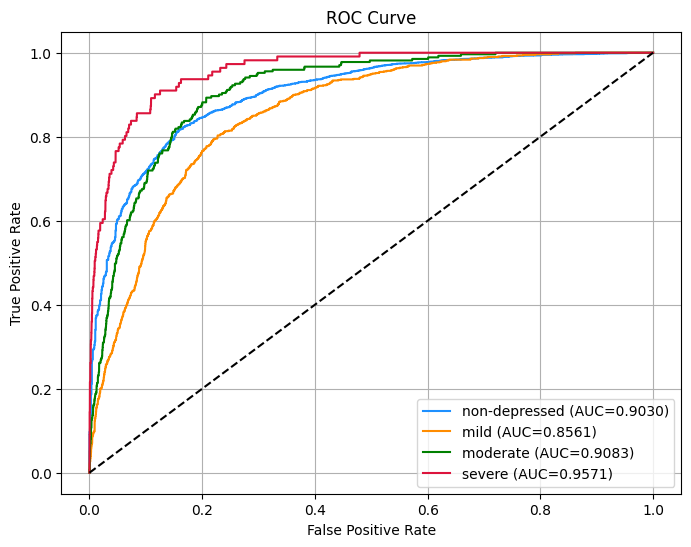

In [6]:
# ✅ Install dependencies
!pip install -q transformers datasets scikit-learn matplotlib

# ✅ Import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

from transformers import AlbertTokenizer, TFAlbertForSequenceClassification, AdamWeightDecay
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# ✅ Load dataset
df = pd.read_csv('/content/SOD22_dataset.csv')

# ✅ Label encoding
label_map = {'non-depressed': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
df['label'] = df['label'].map(label_map)

# ✅ Preprocessing function
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'#\w+', '', text)                          # Remove hashtags
    text = re.sub(r'@\w+', '', text)                          # Remove mentions
    text = re.sub(r'http\S+|www.\S+', '', text)               # Remove URLs
    text = re.sub(r"’", "'", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"[^\w\s]", '', text)                       # Remove punctuation/emojis
    text = re.sub(r'\d+', '', text)                           # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()                  # Remove extra spaces
    return text

df['clean_tweet'] = df['tweet'].apply(preprocess)

# ✅ Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(df['clean_tweet'], df['label'], test_size=0.3, stratify=df['label'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Tokenizer setup
model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(model_name)
max_len = 64

def tokenize(data):
    return tokenizer(
        list(data),
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors='tf'
    )

train_encodings = tokenize(X_train)
val_encodings = tokenize(X_val)
test_encodings = tokenize(X_test)

# ✅ One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

# ✅ TF Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train_cat)).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val_cat)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test_cat)).batch(64)

# ✅ Load model
model = TFAlbertForSequenceClassification.from_pretrained(model_name, num_labels=4)

# ✅ Compile model with correct optimizer
optimizer = AdamWeightDecay(learning_rate=2e-5)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# ✅ Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=3)

# ✅ Predict on test set
logits = model.predict(test_dataset).logits
probs = tf.nn.softmax(logits, axis=1).numpy()
y_pred_labels = np.argmax(probs, axis=1)

# ✅ ROC-AUC score per class
y_test_bin = label_binarize(y_test, classes=[0,1,2,3])
roc_auc = roc_auc_score(y_test_bin, probs, average=None)

# ✅ Plot ROC Curve
fpr = {}
tpr = {}
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])

labels = ['non-depressed', 'mild', 'moderate', 'severe']
colors = ['dodgerblue', 'darkorange', 'green', 'crimson']
plt.figure(figsize=(8,6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{labels[i]} (AUC={roc_auc[i]:.4f})")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
